# Classification of field boundaries

Agricultural practice in the Peak District National Park (PDNP) has created an exten-sive palimpsest of field boundaries amongst other agricultural features such as dew ponds,
ridge and furrow, hedgerows and isolated trees. These features have been created for the most part over the last 600 years and add to the landscape character of the Peak District, which must be conserved and enhanced. However, the PDNP has lost significant lengths of field boundary features since designation.

To date, field boundary data have only been acquired through visual interpretation of aerial or satellite photography or site visits on a case-by-case basis. This requires con-
siderable resources, and therefore does not allow for monitoring boundary changes at a landscape scale. 

In this workbook, we use **1 km2 OS Ordnance Survey National Grid maps, 1940s-1970s — 1:10,560/1:10,000 scale** and the following workflow;

1) OCR and OS data create 'text' and 'urban' masks, 
2) MapReader to create 'non feature of interest' masks, 
3) Contour line mask & binarise the image
4) Probablistic Hough Transform detect boundary features from the 'masked images',
5) Create '1950's wall corridors'
6) Compare with present day Ordnace Survey data for an estinate of loss


In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append('../scripts/')
import mapreader
from mapreader import PatchDataset
import cartopy
from torchvision import models
from torch import nn
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from dotenv import load_dotenv
from osdatahub import NGD
import numpy as np
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
from PIL import Image
import skimage.transform
import cv2
import pandas as pd
import keras_ocr

# Import custom classes **see https://github.com/pdnpa/cnn-boundaries/tree/main/scripts**
from geospatial_masking import Mask, Text_Mask, RasterPlotter, CombinedMask
import historic_wall_inference as hwi

2024-03-07 16:48:59.472452: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 16:48:59.494478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 16:48:59.494499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 16:48:59.495321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 16:48:59.499421: I tensorflow/core/platform/cpu_feature_guar

## 1) OCR, OS & Contour Mask

* Text mask
* OS mask

### Example of keras-ocr text detection

Looking for /home/david/.keras-ocr/craft_mlt_25k.h5
Looking for /home/david/.keras-ocr/crnn_kurapan.h5
2/2 [==============================] - 1s 7ms/step


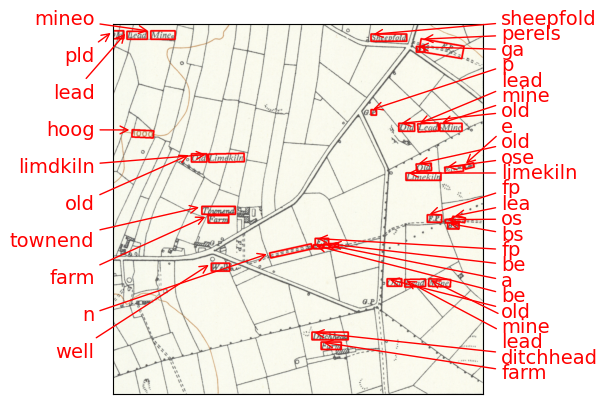

In [15]:
# example image
original_image_path = "../content/tifs/1k_tifs/SK1468.tif"


# Detect text in the image and annotate it
pipeline = keras_ocr.pipeline.Pipeline()
img = keras_ocr.tools.read(original_image_path)
prediction_groups = pipeline.recognize([img])
annotated_image = keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0])

### Example of OS and Text Mask applied to .tif to be passed to MapReader

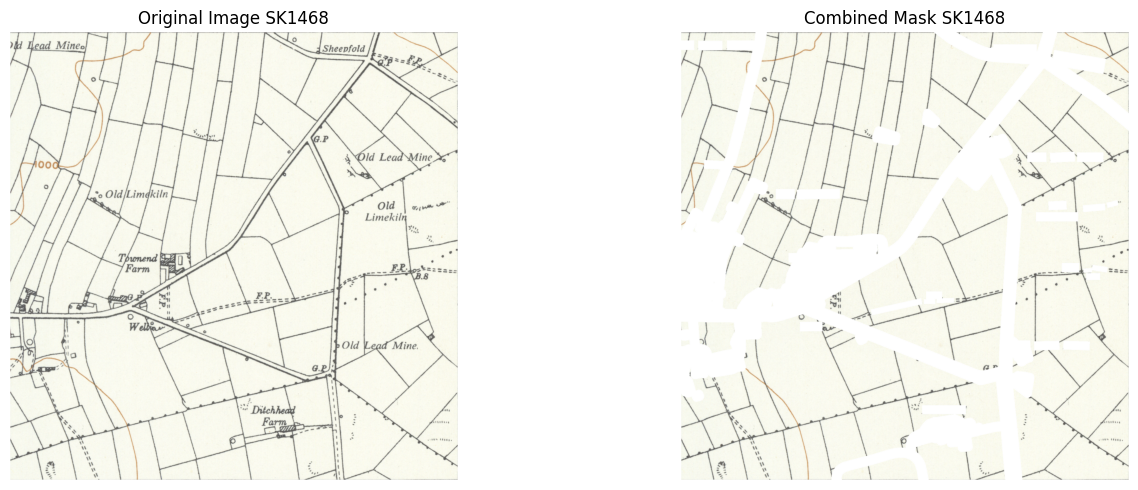

In [19]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub some data collections need admin

# example image
combined_mask_path = "../content/tifs/masked/SK1468_combined.tif"

# Read the images
original_image = Image.open(original_image_path)
combined_mask = Image.open(combined_mask_path)

# Plot the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image SK1468")
plt.axis('off')

# Plot the combined mask
plt.subplot(1, 2, 2)
plt.imshow(combined_mask)
plt.title("Combined Mask SK1468")
plt.axis('off')

plt.tight_layout()
plt.show()

## 2) MapReader Mask

### Load .tif

In [2]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/13 [00:00<?, ?it/s]

#images: 13

#parents: 13
SK1678_combined.tif
SK1570_combined.tif
SK1868_combined.tif
SK1567_combined.tif
SK1474_combined.tif
SK1867_combined.tif
SK1668_combined.tif
SK1469_combined.tif
SK1767_combined.tif
SK1476_combined.tif
SK1768_combined.tif
...

#patches: 0



### Patchify

In [3]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
#my_files.save_patches_as_geotiffs(crs='EPSG:27700')

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/13 [00:00<?, ?it/s]

../content/tifs/masked/SK1678_combined.tif
../content/tifs/masked/SK1570_combined.tif
../content/tifs/masked/SK1868_combined.tif
../content/tifs/masked/SK1567_combined.tif
../content/tifs/masked/SK1474_combined.tif
../content/tifs/masked/SK1867_combined.tif
../content/tifs/masked/SK1668_combined.tif
../content/tifs/masked/SK1469_combined.tif
../content/tifs/masked/SK1767_combined.tif
../content/tifs/masked/SK1476_combined.tif
../content/tifs/masked/SK1768_combined.tif
../content/tifs/masked/SK1070_combined.tif
../content/tifs/masked/SK1468_combined.tif


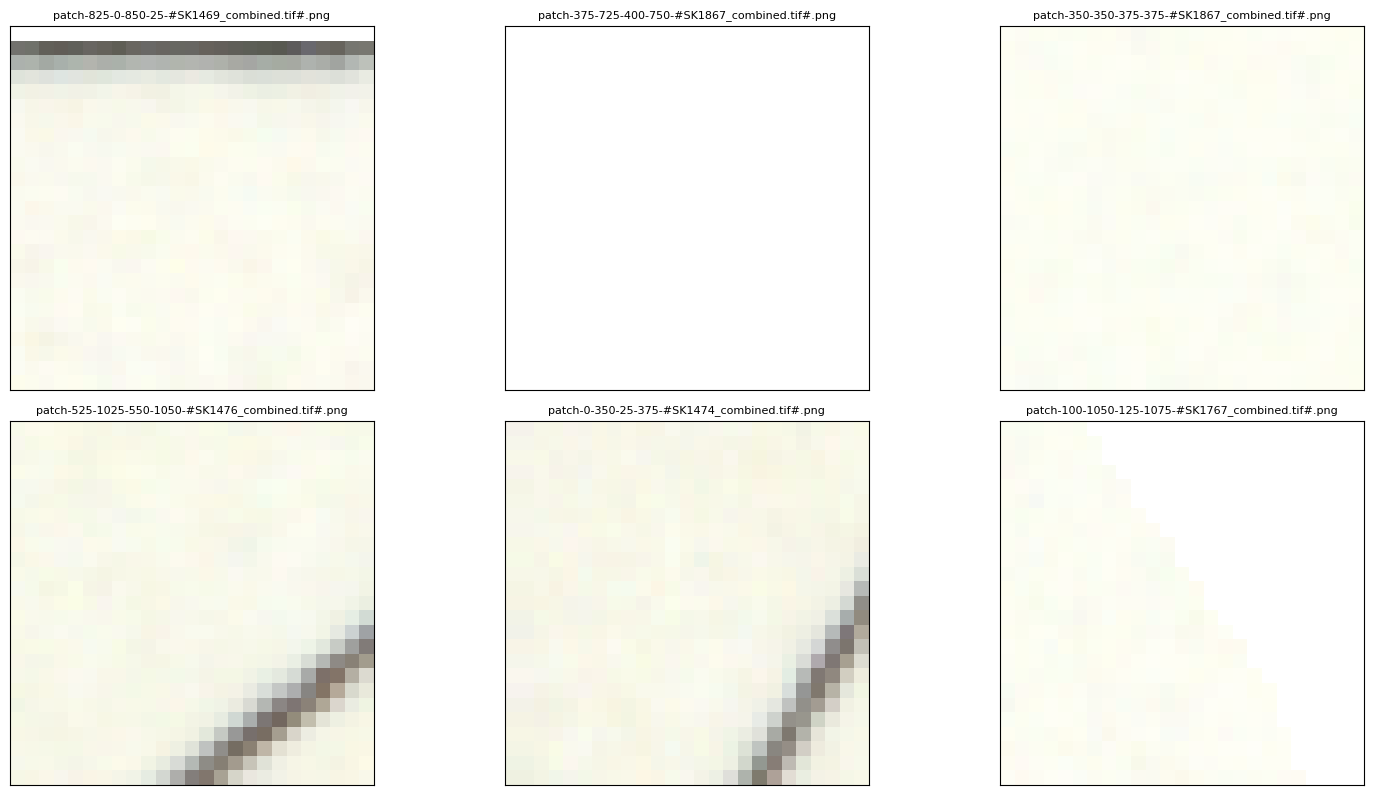

In [4]:
my_files.show_sample(num_samples=6, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

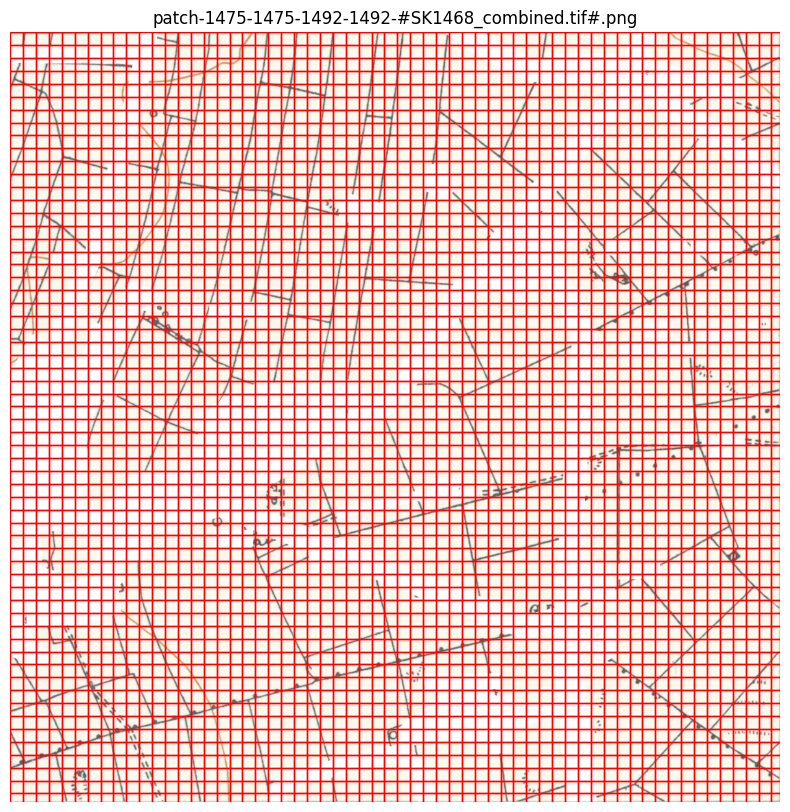

In [5]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[12])

In [7]:
my_files.calc_pixel_stats()

  0%|          | 0/13 [00:00<?, ?it/s]

In [9]:
parent_df, patch_df = my_files.convert_images(save=True)

[INFO] Saved parent dataframe as "parent_df.csv"
[INFO] Saved patch dataframe as "patch_df.csv"


In [13]:
parent_df.head(2)

,parent_id,image_path,coordinates,crs,shape,patches,dlon,dlat
image_id,,,,,,,,
SK1678_combined.tif,None,/home/david/Documents/GitHub/cnn-boundaries/co...,"(-1.7613996386755055, 53.29871213221187, -1.74...",EPSG:4326,"(1492, 1492, 3)","[patch-0-0-25-25-#SK1678_combined.tif#.png, pa...",0.00001,0.000006
SK1570_combined.tif,None,/home/david/Documents/GitHub/cnn-boundaries/co...,"(-1.7767747573977597, 53.226831002780926, -1.7...",EPSG:4326,"(1492, 1492, 3)","[patch-0-0-25-25-#SK1570_combined.tif#.png, pa...",0.00001,0.000006


In [12]:
patch_df.head(2)

,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B
image_id,,,,,,,,,,,,,
patch-0-0-25-25-#SK1678_combined.tif#.png,SK1678_combined.tif,/home/david/Documents/GitHub/cnn-boundaries/co...,"(25, 25, 3)","(0, 0, 25, 25)","(-1.7613996386755055, 53.307524984152764, -1.7...",EPSG:4326,POLYGON ((-1.7611471890918013 53.3075249841527...,0.946918,0.947501,0.897023,0.090833,0.096422,0.091441
patch-0-25-25-50-#SK1678_combined.tif#.png,SK1678_combined.tif,/home/david/Documents/GitHub/cnn-boundaries/co...,"(25, 25, 3)","(0, 25, 25, 50)","(-1.7613996386755055, 53.30737479921853, -1.76...",EPSG:4326,POLYGON ((-1.7611471890918013 53.3073747992185...,0.975347,0.976991,0.925158,0.012042,0.010440,0.019714


### Annotate

In [14]:
from mapreader import Annotator

annotator = Annotator(
    "./patch_df.csv",
    "./parent_df.csv",
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)



[INFO] Loading existing patch annotations.


In [15]:
annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [16]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv'

## Train

### Setup GPU

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-03-07 17:10:35.962773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 17:10:35.963685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 17:10:35.963870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
#### Allow Memeory Growth ####

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth config before initializing GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Initialize the GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-07 17:10:37.827656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 17:10:37.827798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 17:10:37.827890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Read annotations

In [20]:
# Load and check annotations 
import pandas as pd

df = pd.read_csv(annotator.annotations_file, index_col=0)
df["image_id"]=df.index

from mapreader import AnnotationsLoader

annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   1459

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  1016
    - wall:  443



In [21]:
# view the data
annotated_images.annotations.head(2)

,label,image_path,parent_id,pixel_bounds,image_id,label_index
image_id,,,,,,
patch-0-425-25-450-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(0, 425, 25, 450)",patch-0-425-25-450-#SK1070_combined.tif#.png,0
patch-0-550-25-575-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(0, 550, 25, 575)",patch-0-550-25-575-#SK1070_combined.tif#.png,0


## Prepare datasets and dataloaders

In [22]:
annotated_images.create_datasets(frac_train=0.7, frac_val=0.2, frac_test=0.1, context_datasets=True, context_df= "./patch_df.csv")

[INFO] Number of annotations in each set:
    - train:   1021
    - val:   292
    - test:   146


In [23]:
annotated_images.labels_map

{0: 'no_wall', 1: 'wall'}

In [24]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders(batch_size=8)

[INFO] Using default sampler.


## Set up ClassifierContainer

In [25]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cuda:0
[INFO] Initializing model.
[INFO] Loaded "train" with 1021 items.
[INFO] Loaded "val" with 292 items.
[INFO] Loaded "test" with 146 items.


[INFO] dataset: train
        - items:        1021
        - batch size:   8
        - batches:      128


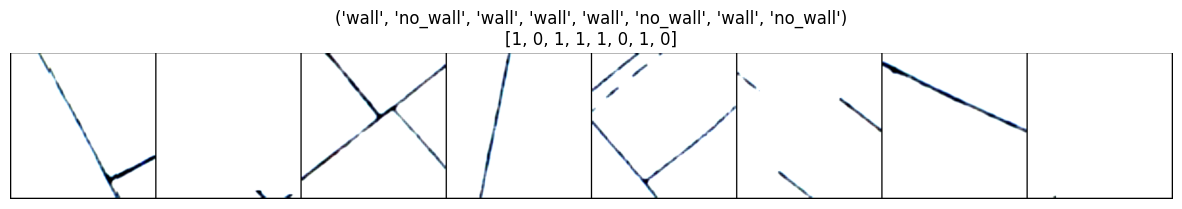

In [26]:
my_classifier.show_sample(set_name="train", batch_number=1)

In [27]:
my_classifier.model_summary()

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #
ResNet                                   [8, 2]                    [8, 2]                    --
├─Conv2d: 1-1                            [8, 64, 112, 112]         [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]           [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3     

### Set up criterion, optimizer and scheduler

In [35]:
# loss function
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [36]:
params_to_optimize = my_classifier.generate_layerwise_lrs(
    min_lr=1e-4, max_lr=1e-3, spacing="geomspace")

In [37]:
my_classifier.initialize_optimizer(params2optimize=params_to_optimize)

In [38]:
# scheduler
my_classifier.initialize_scheduler()

### Train/fine-tune model

In [39]:
my_classifier.train(
    num_epochs=30,
    save_model_dir="./models_tutorial",
    tensorboard_path="tboard_tutorial",
    tmp_file_save_freq=5,
    remove_after_load=False,
    print_info_batch_freq=10,
)

[INFO] Each step will pass: ['train', 'val'].
2024-03-07 17:20:30 david-LEGI [INFO] train    -- 1/30 --     8/1021 (  0.8% ) -- Loss: 0.735
2024-03-07 17:20:34 david-LEGI [INFO] train    -- 1/30 --    88/1021 (  8.6% ) -- Loss: 0.934
2024-03-07 17:20:39 david-LEGI [INFO] train    -- 1/30 --   168/1021 ( 16.5% ) -- Loss: 0.695
2024-03-07 17:20:43 david-LEGI [INFO] train    -- 1/30 --   248/1021 ( 24.3% ) -- Loss: 0.189
2024-03-07 17:20:47 david-LEGI [INFO] train    -- 1/30 --   328/1021 ( 32.1% ) -- Loss: 0.503
2024-03-07 17:20:52 david-LEGI [INFO] train    -- 1/30 --   408/1021 ( 40.0% ) -- Loss: 0.802
2024-03-07 17:20:56 david-LEGI [INFO] train    -- 1/30 --   488/1021 ( 47.8% ) -- Loss: 0.394
2024-03-07 17:21:01 david-LEGI [INFO] train    -- 1/30 --   568/1021 ( 55.6% ) -- Loss: 0.666
2024-03-07 17:21:05 david-LEGI [INFO] train    -- 1/30 --   648/1021 ( 63.5% ) -- Loss: 0.068
2024-03-07 17:21:10 david-LEGI [INFO] train    -- 1/30 --   728/1021 ( 71.3% ) -- Loss: 0.130
2024-03-07 17:

### Plot metrics

In [40]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

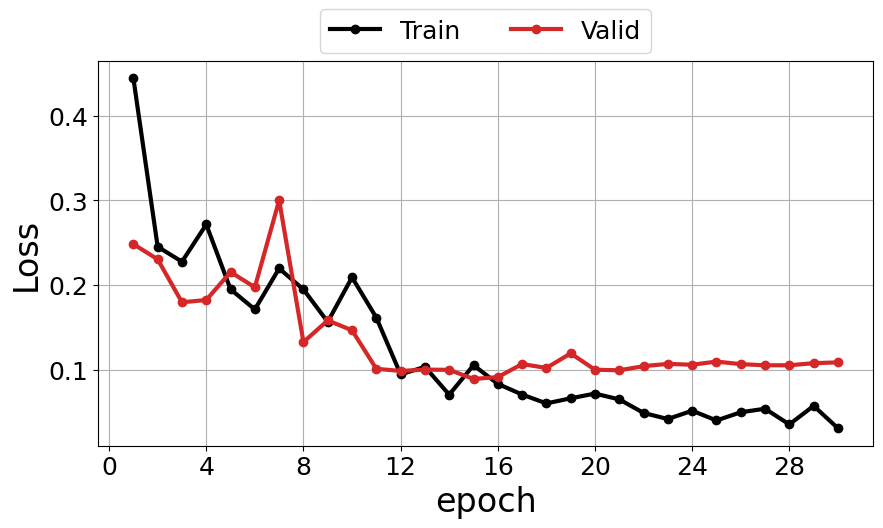

In [41]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Model inference

In [43]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].
2024-03-07 18:14:43 david-LEGI [INFO] test     -- 31/31 --      8/146 (  5.5% ) -- 
2024-03-07 18:14:45 david-LEGI [INFO] test     -- 31/31 --     48/146 ( 32.9% ) -- 
2024-03-07 18:14:47 david-LEGI [INFO] test     -- 31/31 --     88/146 ( 60.3% ) -- 
2024-03-07 18:14:50 david-LEGI [INFO] test     -- 31/31 --    128/146 ( 87.7% ) -- 
[INFO] Total time: 0m 8s


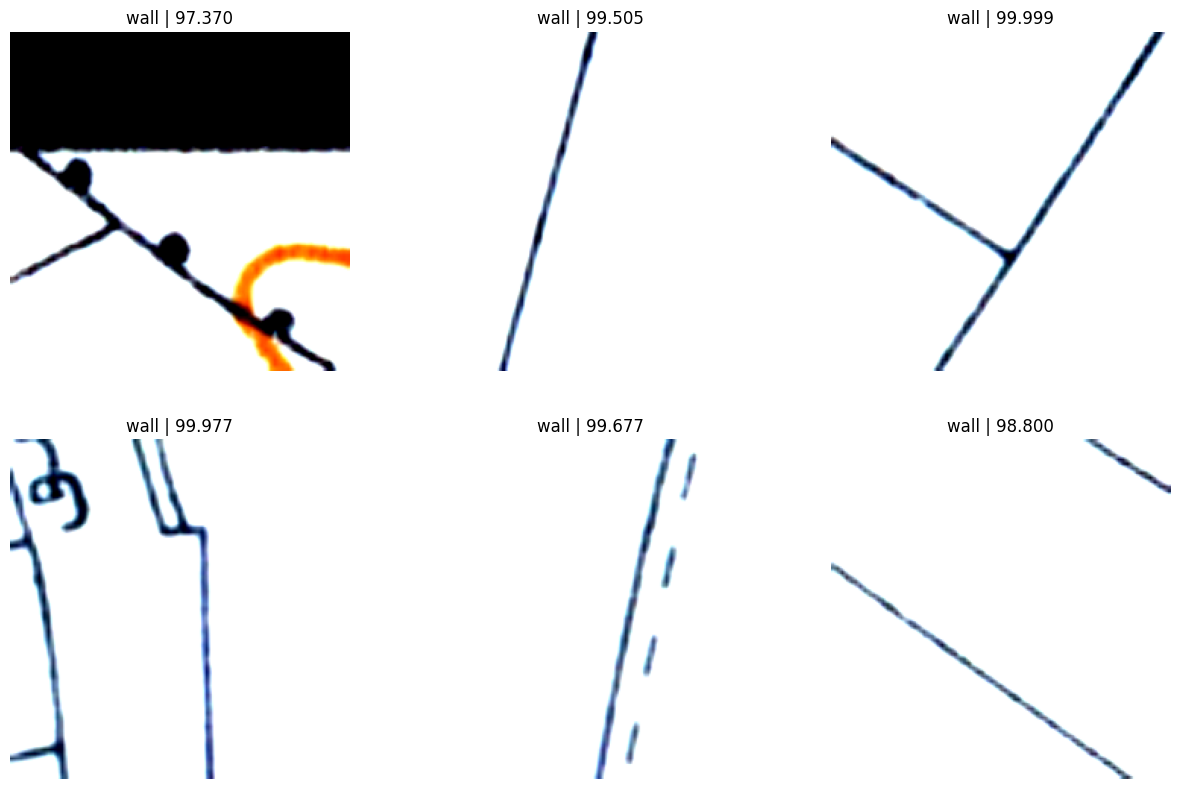

In [44]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

### Save

In [47]:
my_classifier.save("../notebooks/models/test_8.pkl")

### Model Inference

In [48]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-e4d87e68d9487147d69a60da560f20f2.csv".


In [49]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [50]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --    16/1459 (  1.1% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --    96/1459 (  6.6% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   176/1459 ( 12.1% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   256/1459 ( 17.5% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   336/1459 ( 23.0% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   416/1459 ( 28.5% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   496/1459 ( 34.0% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   576/1459 ( 39.5% ) -- 
2024-03-07 18:16:26 david-LEGI [INFO] infer    -- 31/31 --   656/1459 ( 45.0% ) -- 
2024-03-07 18:16:27 david-LEGI [INFO] infer    -- 31/31 --   736/1459 ( 50.4% ) -- 
2024-03-07 18:16:27 david-LEGI [INFO] infer    -- 31/31 --   816/1459 ( 55.9% ) -- 
2024-03-07 18:16:27 david-LEGI [INFO]

### Add predictions to metadata and save

In [51]:
import numpy as np

infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [52]:
infer.patch_df.head(2)

,label,image_path,parent_id,pixel_bounds,predicted_label,pred,conf
image_id,,,,,,,
patch-0-425-25-450-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(0, 425, 25, 450)",no_wall,0,0.997712
patch-0-550-25-575-#SK1070_combined.tif#.png,no_wall,/home/david/Documents/GitHub/cnn-boundaries/co...,SK1070_combined.tif,"(0, 550, 25, 575)",no_wall,0,0.984053


0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

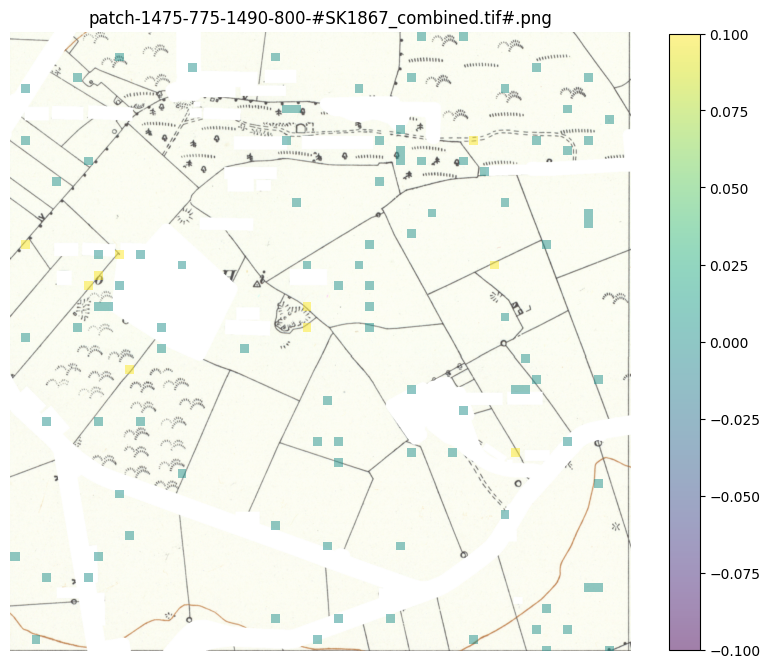

In [53]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[5], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [54]:
patch_df.reset_index(inplace=True, drop=False)
predictions = PatchDataset(patch_df, transform="test")
predictions

In [55]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(predictions, set_name="predictions")

In [56]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --   16/46800 (  0.0% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --   96/46800 (  0.2% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  176/46800 (  0.4% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  256/46800 (  0.5% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  336/46800 (  0.7% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  416/46800 (  0.9% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  496/46800 (  1.1% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  576/46800 (  1.2% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  656/46800 (  1.4% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  736/46800 (  1.6% ) -- 
2024-03-07 18:17:03 david-LEGI [INFO] predictions -- 31/31 --  816/46800 (  1.7% ) --

In [57]:
import numpy as np
predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

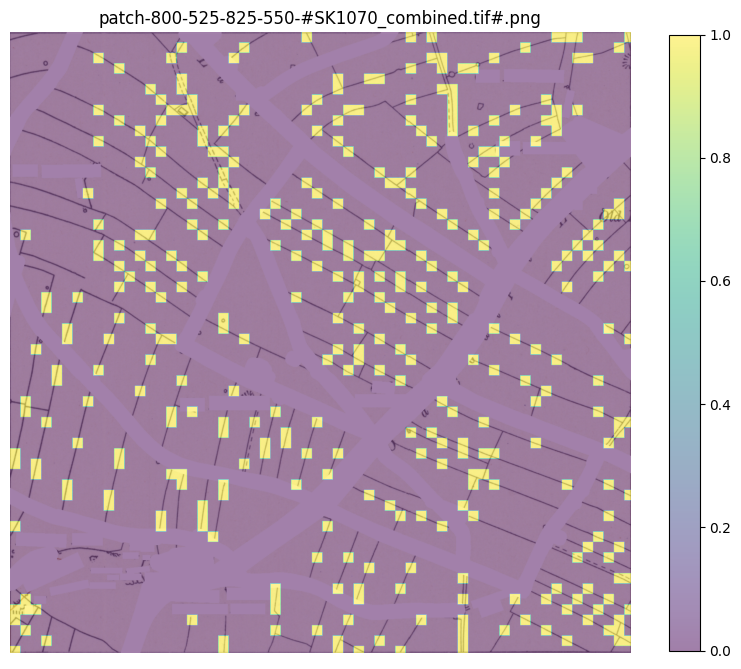

In [58]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

patch_df_predictions = predictions.patch_df
my_maps.add_metadata(patch_df_predictions, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[11], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

In [62]:
import geopandas as gpd

# change tuple columns to strings
for col in patch_df_predictions.columns:
    if isinstance(patch_df_predictions[col][0], tuple):
        patch_df_predictions[col] = patch_df_predictions[col].apply(str)

geo_patch_df = gpd.GeoDataFrame(patch_df_predictions, geometry="polygon", crs='EPSG:4326')
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [54]:
patch_df_predictions.to_csv("../content/predictions/predictions_patch_df.csv", sep=",")

## 3) Contour line mask

## 4) Probablistic Hough Transform

## 5) Create '1950's wall corridors'

## 6) Compare with 2024 Ordnance Survey data